## 参数的更新

训练神经网络的目的是找到使损失函数值尽可能小的参数，这是寻找最优参数的问题，这个过程叫最优化(Optimization)，常见的优化算法：SGD、Momentum、AdaGrad、Adam等

### SGD 随机梯度下降

$$\boldsymbol{W} \leftarrow \boldsymbol{W}-\eta \frac{\partial L}{\partial \boldsymbol{W}}$$

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD的缺点是，如果函数的形状非均向(anisotropic)，比如呈延伸状，搜索的路径就会非常低效。SGD低效的根本原因是，**梯度的方向并没有指向最小值的方向**。

### Monentum

Monentum是动量的意思，来源于物理，引入了一个新变量：物理上的速度 $v$ 

$$\begin{array}{c}{\boldsymbol{v} \leftarrow \alpha \boldsymbol{v}-\eta \frac{\partial L}{\partial \boldsymbol{W}}} \\ {\boldsymbol{W} \leftarrow \boldsymbol{W}+\boldsymbol{v}}\end{array}$$

这种方式物理上的意义表示物体在梯度的方向上受力，在这个力作用下，物体速度增加

In [2]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 保存与参数结构相同的值
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### AdaGrad 学习率衰减

AdaGrad会为参数的每个元素适当地调整学习率

$$\begin{array}{c}{\boldsymbol{h} \leftarrow \boldsymbol{h}+\frac{\partial L}{\partial \boldsymbol{W}} \odot \frac{\partial L}{\partial \boldsymbol{W}}} \\ {\boldsymbol{W} \leftarrow \boldsymbol{W}-\eta \frac{1}{\sqrt{\boldsymbol{h}}} \frac{\partial L}{\partial \boldsymbol{W}}}\end{array}$$

引入新变量 $h$，保存以前所有梯度值的平方和，更新参数时乘以 $\frac{1}{\sqrt{h}}$ 调整学习率的大小

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam

Momentum参照小球在碗中滚动的物理规则进行移动，AdaGrad为参数的每个元素适当地调整更新步伐。Adam方法的基本思路就是将这两个方法融合在一起

### 如何选择使用哪种优化器

并不存在能在所有问题中都表现良好的方法。这4 种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。很多研究中至今仍在使用SGD。Momentum和AdaGrad也是值得一试的方法。最近，很多研究人员和技术人员都喜欢用Adam

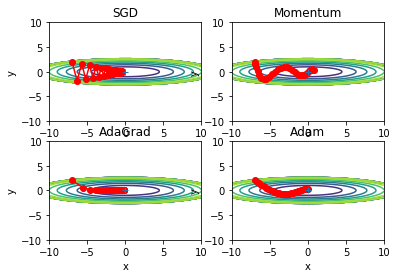

In [5]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0 * y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    mask = Z >=7
    Z[mask] = 0
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

### 几种优化器对于MNIST数字识别的对比

===========iteration:0===========
SGD:2.3280576009529175
Momentum:2.4739124576041256
AdaGrad:1.962089308280655
Adam:2.189898227816838
===========iteration:100===========
SGD:1.4770711524835336
Momentum:0.3750513807655942
AdaGrad:0.14386005985292194
Adam:0.2431257102813854
===========iteration:200===========
SGD:0.8323470608215635
Momentum:0.2935547222084742
AdaGrad:0.10191874661805468
Adam:0.18070000682091658
===========iteration:300===========
SGD:0.7066660694013265
Momentum:0.2803330597926956
AdaGrad:0.12147061842609504
Adam:0.21580267295921784
===========iteration:400===========
SGD:0.5321839889958265
Momentum:0.26002140700883786
AdaGrad:0.09752254836229464
Adam:0.17327291456018712
===========iteration:500===========
SGD:0.3718806974159401
Momentum:0.11451265741991454
AdaGrad:0.04358097826863102
Adam:0.04927981813160122
===========iteration:600===========
SGD:0.43001908413049894
Momentum:0.17338463760827966
AdaGrad:0.10424322157135833
Adam:0.15328523958052775
===========iteration:70

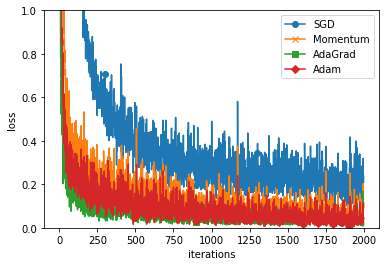

In [6]:
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, train_loss[key], marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 权重的初始值

各层的激活值的分布都要求有适当的广度。为什么呢？因为通过在各层间传递多样性的数据，神经网络可以进行高效的学习。反过来，如果传递的是有所偏向的数据，就会出现**梯度消失**或者**“表现力受限”**的问题，导致学习可能无法顺利进行。

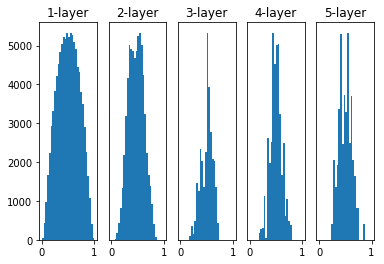

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### sigmoid的权重初始值

Xavier 的论文中，为了使各层的激活值呈现出具有相同广度的分布，推导了合适的权重尺度。推导出的结论是，**如果前一层的节点数为n，则初始值使用标准差为$\frac{1}{\sqrt{n}}$的分布**

In [7]:
node_num = 100 # 前一层的节点数
w = np.random.randn(node_num, node_num) / (np.sqrt(node_num))

### ReLU的权重初始值

Xavier 初始值是以激活函数是线性函数为前提而推导出来的。因为sigmoid函数和tanh函数左右对称，且中央附近可以视作线性函数，所以适合使用Xavier 初始值。但当激活函数使用ReLU时，一般推荐使用ReLU专用的初始值，也就是Kaiming He等人推荐的初始值，也称为“He初始值”

当前一层的节点数为n 时，He 初始值使用标准差为$\sqrt{\frac{2}{n}}$的高斯分布。

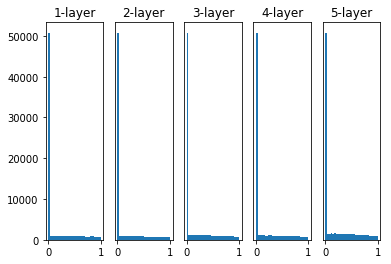

In [16]:
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

## Batch Normalization

Batch Norm 基本思想是为了使各层拥有适当的广度，“强制性”地调整激活值的分布

Batch Norm有以下优点：

- 可以使学习快速进行（可以增大学习率）。
- 不那么依赖初始值（对于初始值不用那么神经质）。
- 抑制过拟合（降低Dropout等的必要性）。

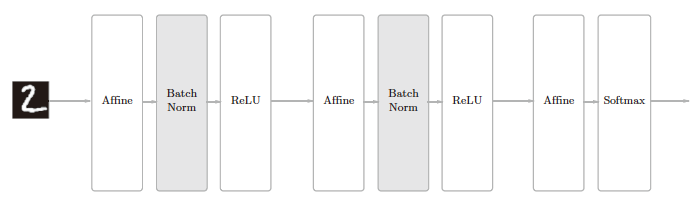

Batch Norm，顾名思义，以进行学习时的mini-batch 为单位，按minibatch进行正规化。具体而言，就是进行使数据分布的均值为0、方差为1 的正规化。用数学式表示的话，如下所示：$$\begin{array}{l}{\mu_{B} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i}} \\ {\sigma_{B}^{2} \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{B}\right)^{2}} \\ {\hat{x}_{i} \leftarrow \frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\varepsilon}}}\end{array}$$

这里对mini-batch 的$m$个输入数据的集合 $B=\left\{x_{1}, x_{2}, \cdots, x_{m}\right\}$ 求均值 $\mu_{B}$ 和方差 $\sigma_{B}^{2}$ 然后对输入数据进行均值为0、方差为1的正规化。$\varepsilon$ 是一个微小值 1e-7， 为了防止出现除0的错误

## 处理过拟合

发生过拟合的原因，主要有以下两个。

1. 模型拥有大量参数、表现力强。
2. 训练数据少。

epoch:0, train acc:0.07333333333333333, test acc:0.0824
epoch:1, train acc:0.08666666666666667, test acc:0.0869
epoch:2, train acc:0.12333333333333334, test acc:0.0915
epoch:3, train acc:0.15333333333333332, test acc:0.1061
epoch:4, train acc:0.19, test acc:0.1277
epoch:5, train acc:0.24, test acc:0.1458
epoch:6, train acc:0.26, test acc:0.1714
epoch:7, train acc:0.30666666666666664, test acc:0.2006
epoch:8, train acc:0.3466666666666667, test acc:0.2293
epoch:9, train acc:0.4033333333333333, test acc:0.2672
epoch:10, train acc:0.44, test acc:0.2925
epoch:11, train acc:0.48333333333333334, test acc:0.3162
epoch:12, train acc:0.49, test acc:0.3335
epoch:13, train acc:0.52, test acc:0.3544
epoch:14, train acc:0.5633333333333334, test acc:0.3785
epoch:15, train acc:0.5833333333333334, test acc:0.4019
epoch:16, train acc:0.58, test acc:0.4122
epoch:17, train acc:0.61, test acc:0.4269
epoch:18, train acc:0.6266666666666667, test acc:0.4358
epoch:19, train acc:0.6666666666666666, test acc:0.4

epoch:160, train acc:1.0, test acc:0.7362
epoch:161, train acc:1.0, test acc:0.7346
epoch:162, train acc:1.0, test acc:0.7351
epoch:163, train acc:1.0, test acc:0.7393
epoch:164, train acc:0.9966666666666667, test acc:0.7397
epoch:165, train acc:1.0, test acc:0.7371
epoch:166, train acc:1.0, test acc:0.7381
epoch:167, train acc:1.0, test acc:0.738
epoch:168, train acc:1.0, test acc:0.7381
epoch:169, train acc:1.0, test acc:0.7369
epoch:170, train acc:1.0, test acc:0.7399
epoch:171, train acc:1.0, test acc:0.7375
epoch:172, train acc:1.0, test acc:0.7367
epoch:173, train acc:1.0, test acc:0.7391
epoch:174, train acc:1.0, test acc:0.7356
epoch:175, train acc:1.0, test acc:0.7347
epoch:176, train acc:1.0, test acc:0.7405
epoch:177, train acc:1.0, test acc:0.7399
epoch:178, train acc:1.0, test acc:0.7386
epoch:179, train acc:1.0, test acc:0.7358
epoch:180, train acc:1.0, test acc:0.7413
epoch:181, train acc:1.0, test acc:0.7397
epoch:182, train acc:1.0, test acc:0.7404
epoch:183, train acc

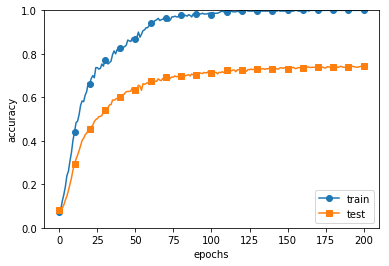

In [17]:
import os, sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
weight_decay_lambda = 0 # 不使用权值衰减的情况
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

过了100 个epoch 左右后，用训练数据测量到的识别精度几乎都为100%。但是，对于测试数据，离100%的识别精度还有较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。

### 权值衰减(惩罚权重)

该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合原本就是因为权重参数取值过大才发生的。

如果将权重记为W，L2 范数的权值衰减就是 $\frac{1}{2} \lambda \boldsymbol{W}^{2}$ ，然后将这个加到损失函数上。这里，$\lambda$是控制正则化强度的超参数。$\lambda$设置得越大，对大的权重施加的惩罚就越重

### Dropout

Dropout 是一种在学习的过程中随机删除神经元的方法。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递。

## 超参数的最优化